# Predicting insurance cross-sales with ML 

## Problem
This project uses machine learning to predict whether or not a current health insurance customer will buy car insurance after being contacted with an offer. The data came [from Kaggle](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction), and the goal is to maximise profit by:
* correctly identifying as non-many buyers as possible,
* while also preserving as many sales as possible. 

## Solution
### Summary
The best-performing machine learning model correctly identifies 52% of leads as non-buyers who should not be contacted. At the same time, the model correctly selects ~98% of the buyers for targetting. The impact of the model is shown in two infographics [at the end of the notebook](#Visualizing-model-impact). If implemented, the model would save between \\$52,000-\\$130,000 per 100,000 leads, depending on how leads are contacted (mail, e-mail or phone).<br>

### Data
A labelled dataset collected about previous sales was used. Apart from the label ('buyer' or 'non-buyer'), it also contains the following information:
* Demographics (gender, age, region)
* Car insurance coverage (previously insured or not, previous damage, monthly premium offered)
* Health insurance coverage (vintage, sales channel)

A training and test set were provided, but since this is a Kaggle challenge, the labels of the test set were not available. To evaluate the performance of the final model after hyperparameter tuning, a separate validation set was created from the training set. 

### Approach
Trained a variety of classifiers using hyperparameter tuning via a grid search with 5-fold cross validation. Next, diverse models were combined to generate a hard voting classifier and a stacking classifier. Finally, all classifiers were evaluated on the validation set. The best performing model was used to generate predictions on the test set for submission to Kaggle.

* Scoring was performed using ROC AUC. The rationale behind this choice is [explained below](#Choosing-metrics).<br><br>
* Classifiers tested:
    * Logsitic regression (various regularisations),
    * Linear support vector classifier,
    * Random forest classifier,
    * KNN classifier, 
    * Naive Bayes classifier.<br><br>
* A combined up-/downsampling step was included because the positive target class (successful sale) occurs much less frequently in the training data. More details on this can be [found below](#Setting-up-pipeline).

## Setup

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn / imblearn tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Sklearn / mlxtend models

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC

# Misc
import warnings
from joblib import dump, load
from plotting_funcs import simplify_ax

warnings.filterwarnings('ignore')

%matplotlib inline

sell_data_train = pd.read_csv('train.csv', index_col='id')
sell_data_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2]:
sell_data_train.shape

(381109, 11)

## Data exploration

In [3]:
# Missing values

sell_data_train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [4]:
# Data types

sell_data_train.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

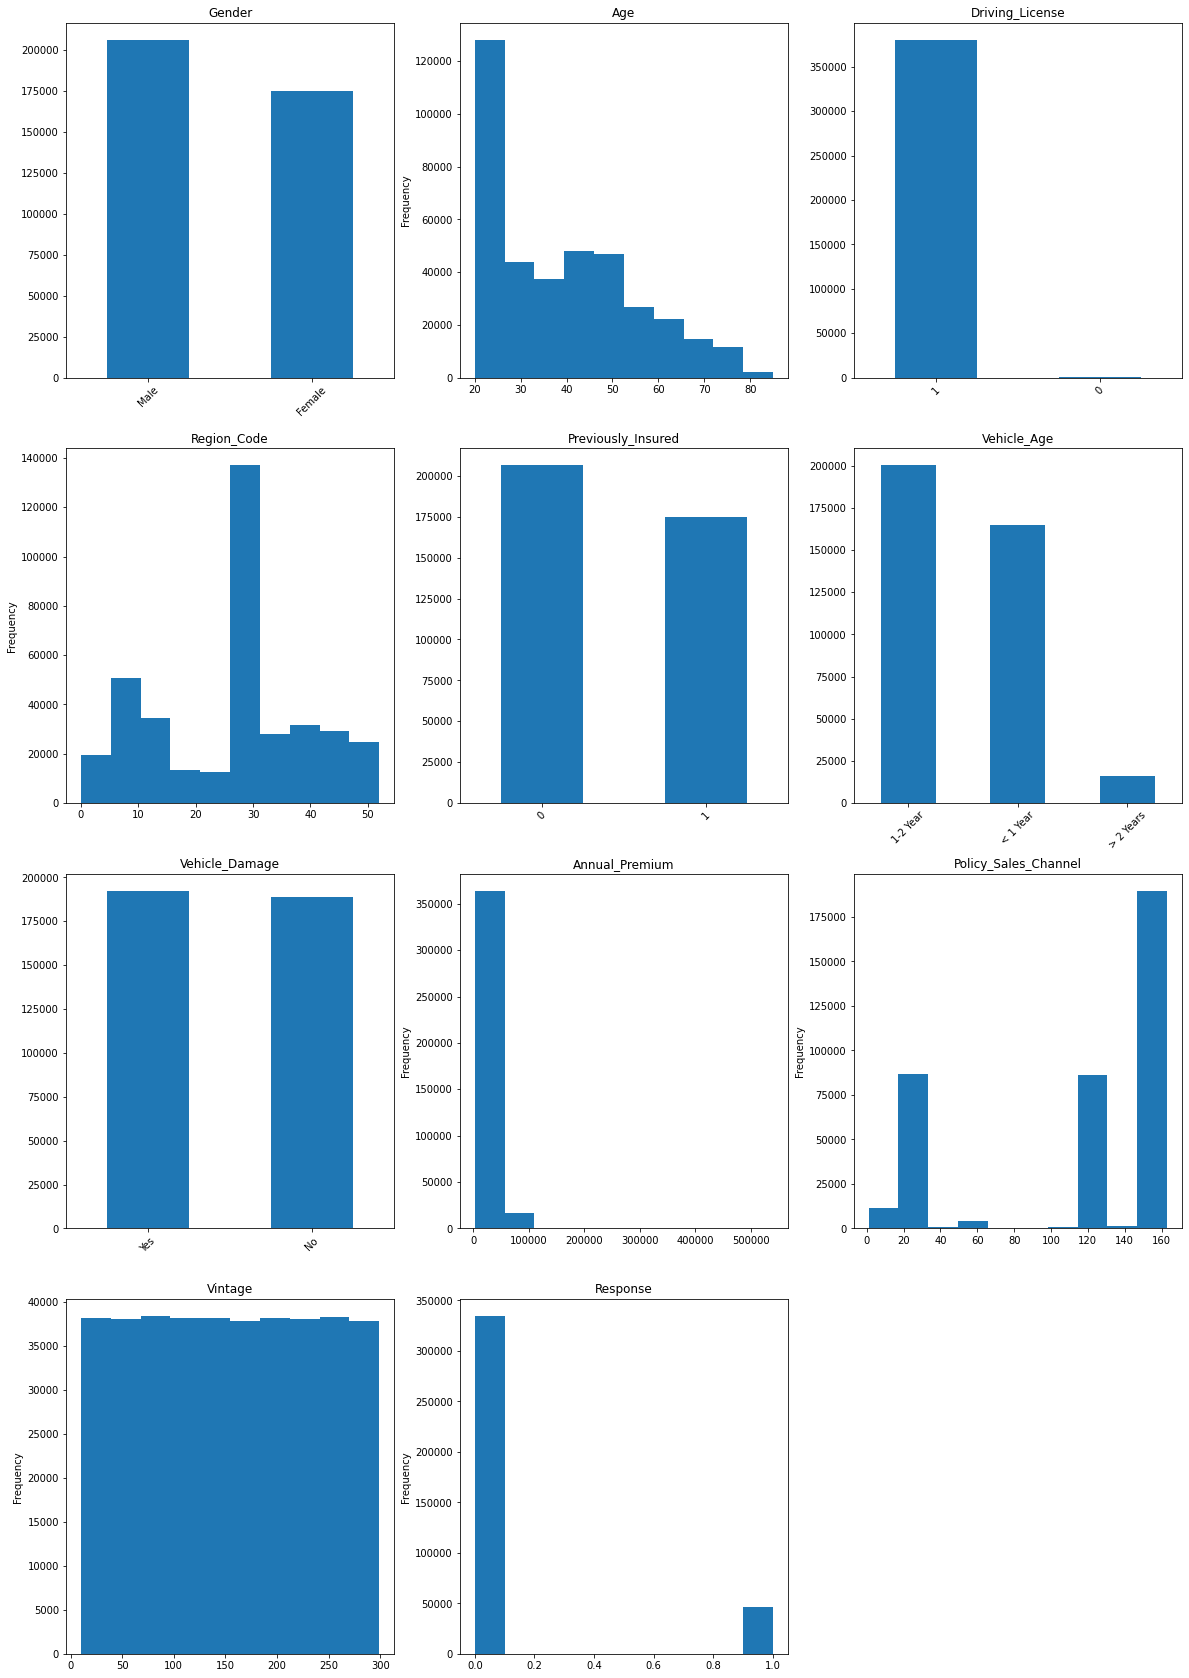

In [5]:
# Visualising distributions 

fig = plt.figure(figsize=(20,30))
axs = []

binary_col = [2,4]

for n in range(11):
    ax = fig.add_subplot(4, 3, n+1)
    col = sell_data_train.columns[n]
    if n in binary_col or sell_data_train[col].dtype == object:
        sell_data_train[col].value_counts(dropna=False).plot(
            kind='bar',
            ax=ax,
            title=sell_data_train.columns[n]
        )
        ax.tick_params(axis='x', rotation=45)
    else:
        sell_data_train[col].plot(kind='hist', ax=ax, title=sell_data_train.columns[n])

(0.0, 150000.0)

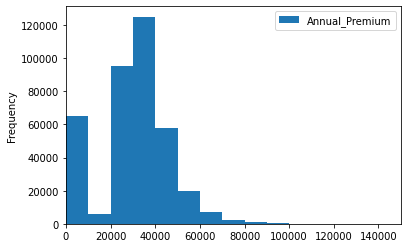

In [6]:
# Annual Premium in more detail

ax = sell_data_train[['Annual_Premium']].plot(kind='hist', bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000])
ax.set_xlim(0,150000)

<b>Some observations / to-do </b><br>
- Need to <b>encode</b> Gender (one-hot), Vehicle_Damage (one-hot), Vehicle_Age (ordinal)
- Need to <b>scale</b> Age, Region_Code, Policy_Sales_Channel, Vintage
- Age, Region_Code, Policy_Sales_Channel are <b>skewed</b>. Check dictionary for meaning of last two columns. Keep in mind for later.
- Driving_License = 1 for all instances, so has no predictive value. Let's drop it. 
- There is significant <b>class imbalance in the target class</b>! The positive class (i.e. successful sale) is much less common. Will use imbalanced-learn library to implement upsampling using SMOTENC.

## Data preparation

In [7]:
# Train/test split

y = np.array(sell_data_train[['Response']])
X = sell_data_train.drop('Response', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.ravel()
y_val = y_val.ravel()

# Using column transformer to: drops license, transform other cols

hot_ft = [0, 6]
ord_ft = [5]
drop_ft = [2]
scale_ft = [1, 3, 8, 9]

ct = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ord_ft),
        ('one_hot', OneHotEncoder(), hot_ft),
        ('scale', MinMaxScaler(), scale_ft),
        ('to_drop', 'drop', drop_ft)
    ], remainder='passthrough')

In [8]:
y_val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
y_train[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [10]:
X_train[:10]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
332804,Female,39,1,15.0,0,1-2 Year,Yes,52906.0,55.0,227
116249,Male,38,1,11.0,0,1-2 Year,Yes,23038.0,26.0,29
255006,Male,22,1,30.0,1,< 1 Year,No,45318.0,152.0,166
317475,Female,23,1,41.0,1,< 1 Year,No,29132.0,151.0,277
344213,Male,56,1,48.0,0,> 2 Years,Yes,2630.0,154.0,155
26230,Male,30,1,18.0,1,< 1 Year,No,35118.0,152.0,92
109100,Male,48,1,28.0,0,1-2 Year,Yes,50341.0,124.0,188
318078,Male,20,1,37.0,0,< 1 Year,Yes,47306.0,160.0,220
104642,Female,23,1,47.0,0,< 1 Year,No,2630.0,152.0,163


## Choosing metrics
**Performance metrics recorded:** Recall, specificity, ROC AUC.
<br><br>**ROC AUC was used to select best estimators - why?**
- The overall goal here is two-fold: to convert as many leads as possible, while not wasting resources on non-buyers.<br>
<br>
- Mathematically speaking, this translates into wanting high recall (many true positives) and low fall-out (low false positives). Unfortunately, there is usually a trade-off between the two, and a good model strikes the right balance between recall and fall-out.<br>
<br>
- **Based on this, I choose ROC AUC as my main metric, because it reflects both recall and fallout.** By optimising the ROC AUC, I hope to find the right balance between identifying buyers and identifying non-buyers.
<br>
<br>
- When using ROC AUC, it is assumed that the opportunity cost of missing a potential buyer is equal to the cost of contacting a lead. This assumption might not hold in this particular case, but I was unable to verify the exact cost of contacting a lead.<br>

In [11]:
metrics = ['roc_auc', 'recall', 'precision']

# Utility function to calculate averages from dictionary returned by cross_validate

def avg_scores(metrics_list, score_dict):
    """Average the metrics returned by sklearn.model_selection.cross_validate() across
    all folds.
    Args:
        metrics_list (list): Metrics passed to cross_validate().
        score_dict (dict): Output of cross_calidate().
    Returns:
        avg_dict (dict): Average of metrics. 
    """
    avg_dict = {}
    for m in metrics_list:
        avg_dict[m] = np.mean(score_dict['test_{}'.format(m)])
    return avg_dict

# Utility function to extract best index, params, score from GridSearchCV results dictionary

def grid_best(metrics_list, gridcv_instance):
    """Takes a GridSearchCV instance and extracts the best index (based on the GridSearchCV refit parameter),
    its hyperparameters and all performance metrics for the model trained with those hyperparameters.
    Args:
        metrics_list (list): Metrics passed to cross_validate().
        gridcv_instance (GridSearchCV)
    Returns:
        best_dict (dict): Best index, hyperparams, metrics.
    """
    best_dict = {}
    best_dict['best_index'] = gridcv_instance.best_index_
    best_dict['best_params'] = gridcv_instance.best_params_
    for m in metrics_list:
        best_dict[m] = gridcv_instance.cv_results_['mean_test_{}'.format(m)][gridcv_instance.best_index_]
    return best_dict

## Setting up pipeline 

Aside from the classifier, the pipieline will include the column transformer and the upsampling step.
<br><br>Upsampling will be implemented usign SMOTENC from imblearn.
<br><br>Because of this, I will use imblearn's own pipeline class. Unlike the sklearn pipeline class, imblearn ensures that the validation set is *not* oversampled. Oversampling in the validation set would distort error metrics.

In [12]:
# Utility function function to generate pipeline with ColumnTransformer, SMOTENC, and a classifier.

def make_pipe(clf):
    """Makes imblearn pipeline with desired classifier and pre-set transformers. 
    Args:
        clf (sklearn estimator): Desired classifier. Inclue desired hyperparameters.
    Returns:
        pipe (imblearn.pipeline.Pipeline) 
    """  
    pipe = Pipeline(steps=[
        ('sampling', SMOTENC(categorical_features=ord_ft+hot_ft, random_state=42, n_jobs=-1)),
        ('transfomer', ct),
        ('clf', clf)
    ], memory='pipe_cache')

    return pipe

## Training and selecting models
### Logistic regression
#### Lasso regularisation
Due to the number of features, I will first try Lasso regression.

In [13]:
log_model = make_pipe(SGDClassifier(loss='log', penalty='l1', random_state=42))

log_scores = cross_validate(log_model, X_train, y_train, scoring=metrics)

log_avg_scores = avg_scores(metrics, log_scores)
print(log_avg_scores)

{'roc_auc': 0.7886522697286023, 'recall': 0.6820530820458581, 'precision': 0.2540935249807958}


#### Hyperparameter tuning using GridSearchCV

Performance is moderate, with a middling ROC AUC and recall and low precision. At the moment, we are correctly identifying some of the real opportunities, but also wasting resources by going after the wrong leads.<br>

Next, I will examine different combinations of hyperparameters systematically using GridSearchCV:
- penalty, defines whether to use Lasso, Ridge or Elastic Net regularisation
- alpha, determines extent of regularisation
- l1_ratio (when using Elastic Net), defines the proportion of Lasso regularisation.

In [14]:
log_param_grid = [
    {'clf__penalty': ['l1', 'l2'], 
    'clf__alpha': [1, 5, 10, 50, 100, 500, 1000]
    },
    {'clf__penalty': ['elasticnet'],
    'clf__l1_ratio': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
    'clf__alpha': [1, 5, 10, 50, 100, 500, 1000]
    }]

log_model = make_pipe(SGDClassifier(loss='log', random_state=42, max_iter=2000))

grid_search_log = GridSearchCV(log_model, log_param_grid, scoring=metrics, refit='roc_auc')
grid_search_log.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

Let's obtain the best parameters, the best index, and the best ROC AUC. I will also obtain the best estimator and save it for future use.

In [16]:
best_estimator_log = grid_search_log.best_estimator_
dump(best_estimator_log, 'models/log_model.joblib')

['models/log_model.joblib']

In [17]:
best_log = grid_best(metrics, grid_search_log)
print(best_log)

{'best_index': 14, 'best_params': {'clf__alpha': 1, 'clf__l1_ratio': 0.05, 'clf__penalty': 'elasticnet'}, 'roc_auc': 0.7659955733341425, 'recall': 0.18472230101138531, 'precision': 0.08389872485606445}


ROC AUC is high, but recall is very low. It seems that logistic regression is not appropriate for this task.

In [18]:
grid_search_log.cv_results_['mean_test_recall']

array([0.4       , 0.2       , 1.        , 0.49089687, 0.8       ,
       0.51298551, 0.        , 0.236525  , 0.        , 0.75803856,
       0.        , 0.74149163, 0.        , 0.65312267, 0.1847223 ,
       0.19835955, 0.4       , 0.4       , 0.36318903, 0.2       ,
       0.36447492, 0.        , 0.2       , 0.4       , 0.4       ,
       0.16307651, 0.        , 0.16318903, 0.        , 0.2       ,
       0.2       , 0.2       , 0.        , 0.        , 0.        ,
       0.6       , 0.16334543, 0.16334543, 0.        , 0.16334543,
       0.16334543, 0.        , 0.2       , 0.2       , 0.        ,
       0.2       , 0.6       , 0.16447492, 0.16447492, 0.16447492,
       0.16447492, 0.16447492, 0.        , 0.        , 0.        ,
       0.16353859, 0.        , 0.        , 0.49079425, 0.49076735,
       0.49074046, 0.49074046, 0.49074046, 0.49117565, 0.49106809,
       0.3250605 , 0.        , 0.        , 0.        , 0.3157187 ,
       0.150437  , 0.        , 0.        , 0.        , 0.     

The 'mean_test_recall' array shows that many models have low recall, but high ROC AUC. These models simply predict most instances to be negative, which does not meet out goal of maximising sales while minimizing marketing expenditure. The SGDClassifier with the best parameters achieves by far the best balance.

### Linear SVC

#### Default parameters

This includes l2 regularization, which did not perform very well on its own in logistic regression. Nonetheless, it will be interesting to see how it compares to logistic regression.<br><br>
(N.B.: SVC with an RBF kernel might work very well for this dataset, but it has very high computational complexity, so I cannot implement it here.)

In [19]:
svc_model = make_pipe(LinearSVC(dual=False, random_state=42))
svc_scores = cross_validate(svc_model, X_train, y_train, scoring=metrics)

svc_avg_scores = avg_scores(metrics, svc_scores)
print(svc_avg_scores)

{'roc_auc': 0.8277368924234663, 'recall': 0.9725442827937881, 'precision': 0.24890504045459508}


ROC AUC is slightly higher than for logistic regression, but recall is much better. Let's see if a grid search can further improve this model.
#### Hyperparameter tuning using GridSearchCV

In [20]:
svc_param_grid = [
    {'clf__penalty': ['l1', 'l2'], 
    'clf__C': [0.1, 0.5, 1, 5, 10, 50, 100]
    }]

grid_search_svc = GridSearchCV(svc_model, svc_param_grid, scoring=metrics, refit='roc_auc')
grid_search_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [21]:
best_estimator_svc = grid_search_svc.best_estimator_
dump(best_estimator_svc, 'models/svc_model.joblib')

best_svc = grid_best(metrics, grid_search_svc)
print(best_svc)

{'best_index': 0, 'best_params': {'clf__C': 0.1, 'clf__penalty': 'l1'}, 'roc_auc': 0.8283952871105408, 'recall': 0.9725173793828905, 'precision': 0.24939707474390493}


In [22]:
grid_search_svc.cv_results_['mean_test_roc_auc']

array([0.82839529, 0.82773318, 0.82836867, 0.82773647, 0.82836916,
       0.82773689, 0.82836956, 0.82773721, 0.82836965, 0.82773723,
       0.82836971, 0.82773726, 0.82836972, 0.82773726])

The best result obtained by grid search is marginally better than the default parameters. Indeed, analysis of the results show that performance does not vary much. This suggests that further hyperparameter tuning is not necessary.<br>

### Random Forest classifier
#### Default parameters

This uses Gini impurity and 100 estimators.

In [23]:
rf_model = make_pipe(RandomForestClassifier(random_state=42))
rf_scores = cross_validate(rf_model, X_train, y_train, scoring=metrics)

rf_avg_scores = avg_scores(metrics, rf_scores)
print(rf_avg_scores)

{'roc_auc': 0.8321887476060619, 'recall': 0.4661038246049463, 'precision': 0.31957850277655797}


#### Hyperparameter tuning using GridSearchCV

In [24]:
rf_param_grid = [
    {'clf__n_estimators':[4, 8, 16, 32, 64, 100, 200],
     'clf__max_depth': [2, 4, 8, 16, 32, 64, 100]
    },
    {'clf__n_estimators':[4, 8, 16, 32, 64, 100, 200],
     'clf__min_samples_split':[0.01, 0.025, 0.05, 0.1, 0.25]
    }]

grid_search_rf = GridSearchCV(rf_model, rf_param_grid, scoring=metrics, refit='roc_auc')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [25]:
best_estimator_rf = grid_search_rf.best_estimator_
dump(best_estimator_rf, 'models/rf_model.joblib')

best_rf = grid_best(metrics, grid_search_rf)
print(best_rf)

{'best_index': 27, 'best_params': {'clf__max_depth': 16, 'clf__n_estimators': 200}, 'roc_auc': 0.8402495230017726, 'recall': 0.7158418679622823, 'precision': 0.31207635854509463}


In [26]:
grid_search_rf.cv_results_

{'mean_fit_time': array([  4.02001977,   4.53648186,   5.43762822,   7.86271205,
         10.61735654,  14.27249351,  25.1409091 ,   4.28706346,
          5.02613716,   6.68177004,   9.51319151,  14.49403915,
         21.38126779,  37.49546194,   4.8007062 ,   5.81303968,
          8.11801186,  12.93511109,  21.79476929,  32.26637883,
         61.46544142,   5.29089799,   7.00119705,  10.62650867,
         17.47942286,  32.20334916,  46.42233248,  88.7330266 ,
          5.51505427,   7.54546642,  11.64567442,  19.81289639,
         36.18635602,  54.41024523, 106.09030018,   5.58921323,
          7.69160743,  11.91694531,  20.48448696,  37.45741549,
         56.45078912, 113.34184375,   5.67713184,   8.00508804,
         12.11766853,  21.04800887,  40.9135942 ,  60.05648575,
        118.48609838,   5.18058023,   6.38749576,  10.08042879,
         16.17237763,  28.70699773,  40.7082922 ,  81.94679332,
          5.14799948,   6.57156863,   9.51225972,  13.90268726,
         25.84877257,  

This represents a good improvement over the random parameters. I will proceed with a finer grid search focussing on the max_depth and n_estimators parameters.

#### Finer grid search

In [29]:
rf_param_grid = [
    {'clf__n_estimators' : [200],
     'clf__max_depth' : np.arange(8,26,2)
    }]

grid_search_rf = GridSearchCV(rf_model, rf_param_grid, scoring=metrics, refit='roc_auc')
grid_search_rf.fit(X_train, y_train)

best_estimator_rf = grid_search_rf.best_estimator_
dump(best_estimator_rf, 'models/rf_model.joblib')

best_rf = grid_best(metrics, grid_search_rf)
print(best_rf)

{'best_index': 4, 'best_params': {'clf__max_depth': 16, 'clf__n_estimators': 200}, 'roc_auc': 0.8402495230017726, 'recall': 0.7158418679622823, 'precision': 0.31207635854509463}


The finer grid search results in the same hyperparameters as the initial search. It is likely that increasing the number of predictors would improve performance. Unfortunately, this isn't feasible due to the computational complexity.

### KNN classifier

In [30]:
knn_model = make_pipe(KNeighborsClassifier())

In [32]:
knn_param_grid = [
    {'clf__n_neighbors':[2, 4, 8, 16],
    'clf__weights':['uniform', 'distance'],
     'clf__p':[1, 2]
    }]

grid_search_knn = GridSearchCV(knn_model, knn_param_grid, scoring=metrics, refit='roc_auc')
grid_search_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [33]:
best_estimator_knn = grid_search_knn.best_estimator_
dump(best_estimator_knn, 'models/knn_model.joblib')

best_knn = grid_best(metrics, grid_search_knn)
print(best_knn)

{'best_index': 13, 'best_params': {'clf__n_neighbors': 16, 'clf__p': 1, 'clf__weights': 'distance'}, 'roc_auc': 0.7820862808132898, 'recall': 0.7798423599682163, 'precision': 0.24355300560257334}


KNN does not perform as well as Random Forest or even Linear SVC. Still, it might be a good addition to a blender or voting classifier, since it is not a type of linear model.

### Naive Bayes classifier

In [34]:
nb_model = make_pipe(GaussianNB())
nb_scores = cross_validate(nb_model, X_train, y_train, scoring=metrics)

nb_avg_scores = avg_scores(metrics, nb_scores)
print(nb_avg_scores)

{'roc_auc': 0.8126037580982018, 'recall': 0.9783257827704859, 'precision': 0.24156557326077682}


In [35]:
# Re-fitting on entire training data and saving Saving model after refitting on entire dataset.

nb_model_re = make_pipe(GaussianNB())
nb_model_re.fit(X_train, y_train)

dump(nb_model_re, 'models/nb_model.joblib')

['models/nb_model.joblib']

Naive Bayes peforms better than KNN, and comes very close to Linear SVC and Random Forest KNN.

## Ensemble methods & evaluation on validation set

Next, I will attempt to improve performance by combining different models through ensemble methods, specifically a Voting Classifier and a Stacking Classifier. Given their favourable performance, I will use combinations consisting of:<br>
* Linear SVC, 
* Random Forest Classifier, 
* KNN Classifier,
* Naive Bayes Classifier.<br>

Logistic regression is *not* included because it did not perform well in cross validation, and because it is a linear model just like linear SVC. This means it's likely that errors in logistic regression and linear SVC are more correlated, which would decrease the overall performance of the ensemble classifiers.

### Evaluating individual models on validation set.

To determine whether an ensemble performs better than any model on its own, we need to first obtain the peformance of each model on the validation set.

In [13]:
# Loading saved classifiers.

svc_clf = load('models/svc_model.joblib')
rf_clf = load('models/rf_model.joblib')
knn_clf = load('models/knn_model.joblib')
nb_clf = load('models/nb_model.joblib')

clfs = [svc_clf, rf_clf, knn_clf, nb_clf]
clf_labels = ['svc', 'rf', 'knn', 'nb']

# Evaluating individual classifiers for comparison with ensemble classifiers.

clf_performance = []

for n in range(len(clfs)):
    c = clfs[n]
    pred = c.predict(X_val)
    
    metrics_dict = {'roc_auc' : roc_auc_score(y_val, pred),
                    'recall' : recall_score(y_val, pred),
                     'precision' : precision_score(y_val, pred)}
    
    clf_performance.append(metrics_dict)

In [14]:
clf_performance_df = pd.DataFrame(clf_performance, index=clf_labels)
print(clf_performance_df)

      roc_auc    recall  precision
svc  0.784292  0.973643   0.255504
rf   0.753456  0.723091   0.323211
knn  0.724881  0.782001   0.251528
nb   0.776692  0.977948   0.247482


### Voting Classifier (using mlxtend)
During cross-validation, the GridSearchCV refit the best estimator on the entire dataset, and I subsequently saved the model using joblib. Therefore, there is no need to re-fit the models prior to evaluation on the validation set. The sklearn VotingClassifier class does not support using pre-fit models, which is why I will use the corresponding class in <b>mlxtend</b>, instead.

Since not all of the classifiers used implement a predict_proba() method, I will use hard voting.

In [15]:
vote_clf = EnsembleVoteClassifier(clfs=clfs, fit_base_estimators=False, voting='hard')
vote_clf.fit(X_train, y_train)

# Making predictions on validation set

vote_pred = vote_clf.predict(X_val)

vote_dict = {'roc_auc' : roc_auc_score(y_val, vote_pred),
             'recall' : recall_score(y_val, vote_pred),
             'precision' : precision_score(y_val, vote_pred)}

In [16]:
clf_performance_df = clf_performance_df.append(vote_dict, ignore_index = True)
clf_performance_df.index = ['svc', 'rf', 'knn', 'nb', 'voting']
print(clf_performance_df)

         roc_auc    recall  precision
svc     0.784292  0.973643   0.255504
rf      0.753456  0.723091   0.323211
knn     0.724881  0.782001   0.251528
nb      0.776692  0.977948   0.247482
voting  0.781557  0.898036   0.276844


Surprisingly, the performance of the voting classifier is lower than that of the strongest classifier (SVC). Let's move on to a stacking classifier.

### Stacking Classifier

Since stacking classifiers are not defined in sklearn, there are several steps to take:

1. Layer one - base estimators
    * Further split training set into training and holdout set (80-20 split)
    * Train base estimators on new, reduced training set,
    * Make predictions on **holdout set** with all the base estimators of the first layer.<br><br>
2. Layer two - blender
    * Evaluate stacking classifier on holdout set using cross_validate() (for comparison with other models). 
        * Uses **first layer outputs on holdout set** as features.
    * Training second layer on entire first layer predictions.<br><br>    
3. Make stacked predictions on validation set
    * Make predictions with first layer,
    * Pass to blender.       

#### Step 1a: Creating holdout set

In [17]:
y = np.array(sell_data_train[['Response']])
X = sell_data_train.drop('Response', axis=1)

X_train2, X_h, y_train2, y_h = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train2 = y_train2.ravel()
y_h = y_h.ravel()

In [18]:
print(X_h.shape)
X_h.head()

(60978, 10)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
147167,Female,25,1,35.0,1,< 1 Year,No,31888.0,160.0,269
373211,Male,60,1,50.0,0,> 2 Years,Yes,31875.0,124.0,45
210821,Female,22,1,15.0,1,< 1 Year,No,37338.0,152.0,270
353012,Male,69,1,48.0,0,1-2 Year,Yes,2630.0,26.0,148
228807,Male,66,1,28.0,0,1-2 Year,Yes,39486.0,55.0,248


In [19]:
y_h.shape

(60978,)

#### Step 1b: Training first layer

In [20]:
class FirstLayer:
    """First layer of a stacking classifier or regressor.
    Args:
        models (list): Estimators to be used in the first layer. Must have been trained and must
            implement .predict() method. Do not pre-train on entire training data. Sub-divide instead.
    Attributes:
        models (list): Estimators included in first layer.
    """
    def __init__(self, models):
        self.models = models
     
    def predict(self, X):
        """Makes first-layer predictions. 
        Args:
            X (array-like): Training-data.
        Returns:
            pred (dict): Predictions.
        """
        pred = []
        for i in range(len(self.models)):
            model = self.models[i]
            y_hat_i = model.predict(X)
            pred.append(y_hat_i)
        return np.column_stack(pred)

In [21]:
# Re-training base estimators on smaller training set and saving for future use.

clf_filenames = ['svc_stacking.joblib', 'rf_stacking.joblib', 'knn_stacking.joblib', 'nb_stacking.joblib']

for n in range(len(clfs)):
    c = clfs[n]
    c.fit(X_train2, y_train2)
    
    dump(c, 'models/' + clf_filenames[n])

Partially commented, since re-trained classifiers have already been loaded.

In [22]:
svc_clf = load('models/svc_stacking.joblib')
rf_clf = load('models/rf_stacking.joblib')
knn_clf = load('models/knn_stacking.joblib')
nb_clf = load('models/nb_stacking.joblib')

clfs = [svc_clf, rf_clf, knn_clf, nb_clf]

first_layer = FirstLayer(clfs)

#### Step 2a: Cross-validating stacking classifier
For the second layer, sklearn's implementation of Gradient Boosting will be used.

In [23]:
class SecondLayer:
    """Second layer of a stacking classifier or regressor.
    Args:
        first_layer: Instance of FirstLayer containing desired estimators. 
        blender: Estimator for blending the first layer predictions.
            Must implement .predict() method.        
    Attributes:
        first_layer: FirstLayer estimators.
        blender: Second layer estimator. 
    """
    def __init__(self, first_layer, blender):
        self.first_layer = first_layer
        self.blender = blender
        self.trained = False

    def cross_validate(self, X, y, metric):
        """Convenience wrapper for first_layer.predict() and sklearn.model_selection.cross_validate().
        Args:
            X (array-like): Features. 
            y (array-like): Targets.
            metric: Scorers to be used for cross validation.
        Returns: 
            See sklearn.model_selection.cross_validate()"""
        first_layer_pred = self.first_layer.predict(X)
        cv_output = cross_validate(
            self.blender,
            first_layer_pred,
            y,
            scoring=metric)        
        return cv_output

    def fit(self, X, y):
        """Convenience wrapper calling the blender's .fit() method.
        Args:
            X (array-like): Features. 
            y (array-like): Targets."""
        first_layer_pred = self.first_layer.predict(X)
        self.blender = self.blender.fit(first_layer_pred, y)
        self.trained = True
        
    def stacked_predict(self, X):
        """Makes stacked predictions of first and second layer."""
        if self.trained == True:
            first_layer_pred = self.first_layer.predict(X)
            pred = self.blender.predict(first_layer_pred)
        else:
            raise ValueError('Blender has not yet been trained.')
        return pred

In [24]:
from imblearn.over_sampling import SMOTE

blender = Pipeline(steps=[
        ('sampling', SMOTE(random_state=42, n_jobs=-1)),
        ('clf', GBC(random_state=42, n_estimators=200))
    ], memory='smote_cache')

second_layer = SecondLayer(first_layer, blender)

second_scores = second_layer.cross_validate(X_h, y_h, metrics)

second_performance = avg_scores(metrics, second_scores)
second_performance

{'roc_auc': 0.8266802169734362,
 'recall': 0.9739587764759603,
 'precision': 0.2518815867021172}

Cross-validation performance of the stacking classifier slightly exceeds the performance of individual classifiers.

#### Step 2b: Training second layer on entire holdout set

In [25]:
second_layer.fit(X_h, y_h)

#### Step 3: Making predictions on validation set

In [26]:
pred = second_layer.stacked_predict(X_val)

stacking_dict = {'roc_auc' : roc_auc_score(y_val, pred),
                'recall' : recall_score(y_val, pred),
                'precision' : precision_score(y_val, pred)}

print(stacking_dict)

{'roc_auc': 0.7847944526595875, 'recall': 0.973957786411845, 'precision': 0.2558903051371186}


In [27]:
clf_performance_df = clf_performance_df.append(stacking_dict, ignore_index=True)
clf_performance_df.index = ['svc', 'rf', 'knn', 'nb', 'voting', 'stacking']
print(clf_performance_df)

           roc_auc    recall  precision
svc       0.784292  0.973643   0.255504
rf        0.753456  0.723091   0.323211
knn       0.724881  0.782001   0.251528
nb        0.776692  0.977948   0.247482
voting    0.781557  0.898036   0.276844
stacking  0.784794  0.973958   0.255890


In [28]:
clf_performance_df.to_csv('val_perf.csv')

Using a stacking classifier provides a negligible performance boost. Because of this, I would suggest to implement the Linear SVC, instead. It is a simpler model which makes it easier to maintain. Additionally, it is easier to explain to non-technical stakeholders, which could improve buy-in.

## Plotting classifier performance

In [29]:
perf = pd.read_csv('val_perf.csv', index_col=0)
perf.sort_values('roc_auc', inplace=True)

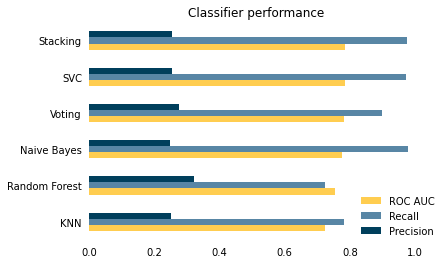

In [30]:
c = ['#ffcd50', '#5886a5','#003f5c']

ax = perf.plot(kind='barh', title='Classifier performance', color=c)
simplify_ax(ax)
ax.legend(loc='lower left', labels=['ROC AUC', 'Recall', 'Precision'],
    bbox_to_anchor=(0.8, 0), ncol=1, 
    borderaxespad=0, frameon=False)
ax.set_yticklabels(['KNN', 'Random Forest', 'Naive Bayes', 'Voting', 'SVC', 'Stacking'])

plt.show()

## Model impact

### <i>Status quo</i>: No model, contact every lead

In [31]:
response_prop = sell_data_train['Response'].value_counts(normalize=True)
response_prop

0    0.877437
1    0.122563
Name: Response, dtype: float64

In [32]:
status_quo_100 = (response_prop*100).round(2)
status_quo_100

0    87.74
1    12.26
Name: Response, dtype: float64

The dataset shows a 12.3% lead-to-customer conversion rate. In other words, ~12 per 100 contacted will buy without pre-selection.

### With a model (linear SVC)

Assumptions: Only positive predictions are contacted. Conversion occurs at a level equivalent to the model's recall.

In [33]:
svc_clf = load('models/svc_model.joblib')
y_val_pred = svc_clf.predict(X_val)

cf_matrix = confusion_matrix(y_val, y_val_pred)
cf_matrix_100 = (cf_matrix / len(y_val) * 100).round(2)
tn, fp, fn, tp = cf_matrix_100.ravel()

cf_matrix_100

array([[52.06, 35.45],
       [ 0.33, 12.16]])

In [34]:
responses = pd.Series(cf_matrix_100.sum(axis=0).round().astype(int), name='Predicted Response')
responses

0    52
1    48
Name: Predicted Response, dtype: int32

#### Visualizing model impact

The model correctly identifies 52% of leads as non-buyers, but also misses 0.33% of leads that are buyers.<br>
The model selects 48% of leads for targeting. This group includes the 12% of the leads that are buyers.

![Visualizing model impact](model_impact_infographic.png)